# RandomForest
## 欠損値補完
* Fare: 欠損レコードの「Pclass=3」「Embarked=S」の平均運賃(=14.43)で補完
* Embarked: 欠損レコードは共に「Pclass=1st」。条件付き確率の最も高い「S」で補完

## 外れ値処理
* 木系のため特に実施せず

## 特徴量
* Pclass: そのまま利用
* Sex: Label Count Rank Encoding
* Age: 「5才以下」「5〜15才(2nd以上)」「5〜10才（3rd）」「10〜15才（3rd）」「15〜60才」「60才以上」「欠損値」「推定値」にカテゴリ化しLabel Count Rank Encoding
* SibSp: そのまま利用
* Parch: そのまま利用
* Fare: そのまま利用
* Embarked: Label Count Rank Encoding

In [1]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

from titanic_package.titanic_preprocess import get_age_ctgr
from titanic_package.titanic_preprocess import get_binned_data
from titanic_package.titanic_preprocess import calc_label_count_rank_encoding

from titanic_package.titanic_plot import plot_survival_rate
from titanic_package.titanic_plot import plot_rf_tuning_result
from titanic_package.titanic_plot import plot_rf_param_tuning_result

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Data load
titanic_train = pd.read_csv('./data/train.csv')
titanic_test = pd.read_csv('./data/test.csv')

In [3]:
# 学習/評価データをマージ
titanic_train['Type'] = 'train'
titanic_test['Type'] = 'test'
titanic_test['Survived'] = np.NaN

titanic_all = pd.concat([titanic_train, titanic_test], ignore_index=True, sort=True)
train_flg = titanic_all['Type'] == 'train'
test_flg = titanic_all['Type'] == 'test'

In [4]:
# 欠損値補完
# Fare
## 運賃は「チケットクラス」「乗船港」で決まると考える
## 欠損レコードは「Pclass=3」「Embarked=S」なのでその平均運賃で補完する
f = (titanic_all['Pclass'] == 3) & (titanic_all['Embarked'] == 'S')
fare_mean = np.mean(titanic_all[f]['Fare'].dropna())

titanic_all['Fare'] = titanic_all['Fare'].fillna(fare_mean)

# Embarked
## 欠損の2人は1stクラス。条件付き確率が最も高い「S」で補完
titanic_all['Embarked'] = titanic_all['Embarked'].fillna('S')

In [5]:
# 年齢カテゴリを作成
## 「5才以下」「5〜15才(2nd以上)」「5〜10才（3rd）」「10〜15才（3rd）」「15〜60才」「60才以上」「欠損値」「推定値」
age_ctgr_list = []

for index, row in titanic_all.iterrows():
    age_ctgr = get_age_ctgr(row['Age'], row['Pclass'])
    age_ctgr_list.append(age_ctgr)

titanic_all['AgeCtgr'] = age_ctgr_list

In [6]:
# カテゴリ変数のエンコーディング
## Label Count Rank Encoding

## 性別
titanic_all['Sex_code'] = calc_label_count_rank_encoding(titanic_all, 'Sex')

## 年齢カテゴリ
titanic_all['AgeCtgr_code'] = calc_label_count_rank_encoding(titanic_all, 'AgeCtgr')

## 出港地
titanic_all['Embarked_code'] = calc_label_count_rank_encoding(titanic_all, 'Embarked')

# エンコーディング結果の確認

## AgeCtgr

            Survived  count
AgeCtgr                    
00-05          70.5%     44
05-10(3rd)     18.8%     16
05-15(2nd+)   100.0%      9
10-15(3rd)     46.2%     13
15-60          39.6%    593
60+            23.8%     21
estimated       5.6%     18
nan            29.4%    177


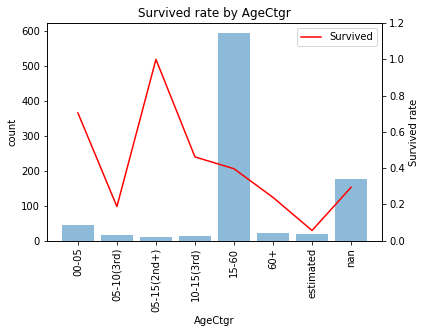

In [7]:
feature = 'AgeCtgr'
plot_survival_rate(feature, titanic_all)

             Survived  count
AgeCtgr_code                
1               39.6%    593
2               29.4%    177
3               70.5%     44
4                5.6%     18
5               23.8%     21
6               18.8%     16
7              100.0%      9
8               46.2%     13


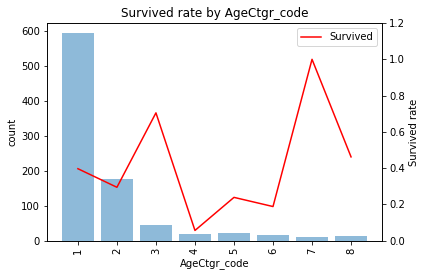

In [8]:
feature = 'AgeCtgr_code'
plot_survival_rate(feature, titanic_all)

## Embarked

         Survived  count
Embarked                
C           55.4%    168
Q           39.0%     77
S           33.9%    646


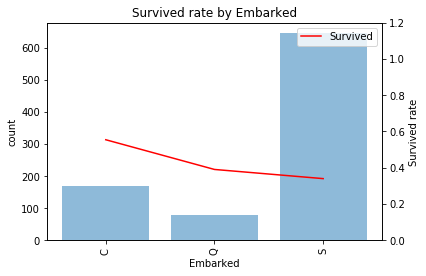

In [9]:
feature = 'Embarked'
plot_survival_rate(feature, titanic_all)

              Survived  count
Embarked_code                
1                33.9%    646
2                55.4%    168
3                39.0%     77


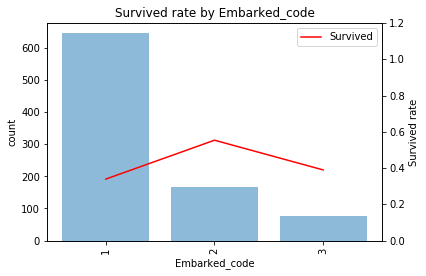

In [10]:
feature = 'Embarked_code'
plot_survival_rate(feature, titanic_all)

In [11]:
# 学習／テスト用データに分割
features = ['Pclass', 'Sex_code', 'AgeCtgr_code', 'SibSp', 'Parch', 'Fare', 'Embarked_code']
X = titanic_all[features]

X_train = X[train_flg]
y_train = titanic_all[train_flg]['Survived'].astype(int)

X_test = X[test_flg]

In [12]:
# 相関を確認
cor_matrix = X_train.corr()

# リスト形式に変換
cor_list = pd.DataFrame()

for i, col1 in enumerate(X_train.columns):
    for j in range(i+1, len(X_train.columns)):
        col2 = X_train.columns[j]
        cor = cor_matrix[col1][col2]
        cor_df = pd.DataFrame([[col1, col2, cor]])
        
        cor_list = pd.concat([cor_list,  cor_df], axis=0)

cor_list.columns = ['Feature1', 'Feature2', 'cor']
cor_list.reset_index(drop=True, inplace=True)
cor_list['abs_cor'] = abs(cor_list['cor'])
cor_list.sort_values(by='abs_cor', ascending=False, inplace=True)

# 相関係数（絶対値）のTop5
cor_list[0:5]

,Feature1,Feature2,cor,abs_cor
4,Pclass,Fare,-0.549500,0.549500
15,SibSp,Parch,0.414838,0.414838
8,Sex_code,Parch,0.245489,0.245489
11,AgeCtgr_code,SibSp,0.236701,0.236701
18,Parch,Fare,0.216225,0.216225


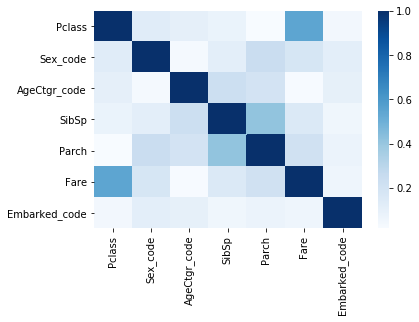

In [13]:
# 相関行列をheatmapで表示
abs_cor_matrix = abs(cor_matrix)

sns.heatmap(abs_cor_matrix,
            xticklabels=X_train.columns,
            yticklabels=X_train.columns,
            cmap='Blues'
           )

# RandomForest
## パラメタチューニング1回目

In [14]:
# モデルチューニング
model = RandomForestClassifier(random_state=0)

n_estimators_params = [50, 100, 200] # default=100
max_depth_params = [1, 3, 5, 7]
max_features_params = [2, 3, 4]   # default=sqrt(#features)=2.6

parameters = {
    'n_estimators': n_estimators_params,
    'max_features': max_features_params,
    'max_depth': max_depth_params
}

# パラメタチューニング
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

model_tuning = GridSearchCV(
    estimator = model,   # 識別器
    param_grid = parameters,    # パラメタ
    scoring='neg_log_loss',    # LogLossで評価
    refit = 'neg_log_loss',       # LogLoss最小パラメタで学習データ全体を再学習
    cv = skf,                      # Stratified Cross validation                      
    n_jobs = -1,               # 並列実行数(-1: コア数で並列実行)
    verbose = 1,                # メッセージ出力レベル
    iid = False,
)

model_tuning.fit(X_train, y_train)
print('Finished')

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.9s


Finished


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   14.2s finished


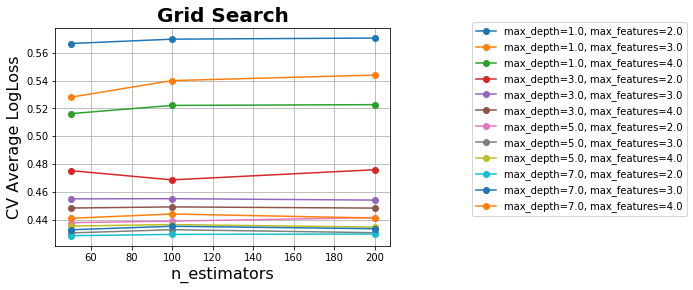

In [15]:
# チューニングの全体結果
plot_rf_tuning_result(model_tuning, 'n_estimators')

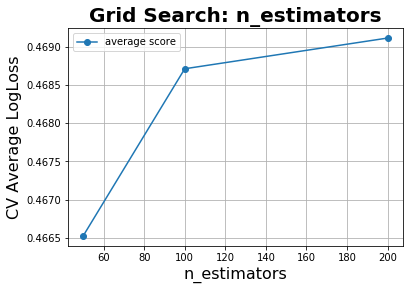

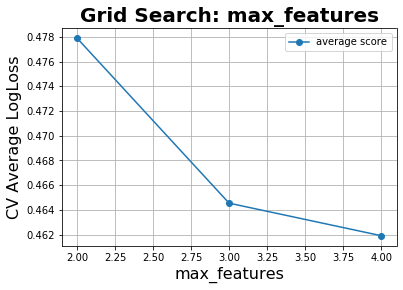

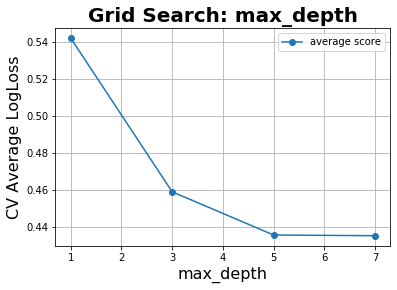

In [16]:
plot_rf_param_tuning_result(model_tuning, 'n_estimators')
plot_rf_param_tuning_result(model_tuning, 'max_features')
plot_rf_param_tuning_result(model_tuning, 'max_depth')

In [17]:
# ベストパラメタ
print('* Best Log Loss: {:.3f}'.format(-model_tuning.best_score_))
print('* Best parameter: {}'.format(model_tuning.best_params_))

* Best Log Loss: 0.429
* Best parameter: {'max_depth': 7, 'max_features': 2, 'n_estimators': 50}


## パラメタチューニング1回目: まとめ
* Best Log Loss: 0.429
* Best parameter: {'max_depth': 7, 'max_features': 2, 'n_estimators': 50}
* n_estimators: 50がbest
  * 50周辺を探索
* max_features: 2がbest
  * [1, 3]に変更
* max_depth: 最大値 7がbest
  * もう少し大きい値も試す

## パラメタチューニング2回目

In [18]:
# モデルチューニング
model = RandomForestClassifier(random_state=0)

n_estimators_params = [25, 50, 75]
max_features_params = [2, 3, 4]
max_depth_params = [7, 8, 9]

parameters = {
    'n_estimators': n_estimators_params,
    'max_features': max_features_params,
    'max_depth': max_depth_params
}

# パラメタチューニング
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

model_tuning = GridSearchCV(
    estimator = model,   # 識別器
    param_grid = parameters,    # パラメタ
    scoring='neg_log_loss',    # LogLossで評価
    refit = 'neg_log_loss',       # LogLoss最小パラメタで学習データ全体を再学習
    cv = skf,                      # Stratified Cross validation                      
    n_jobs = -1,               # 並列実行数(-1: コア数で並列実行)
    verbose = 1,                # メッセージ出力レベル
    iid = False,
)

model_tuning.fit(X_train, y_train)
print('Finished')

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.4s


Finished


[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    4.2s finished


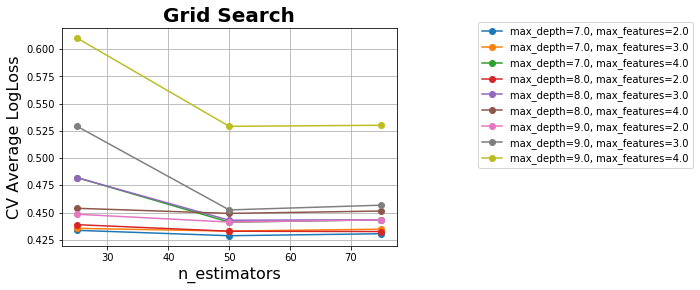

In [19]:
# チューニングの全体結果
plot_rf_tuning_result(model_tuning, 'n_estimators')

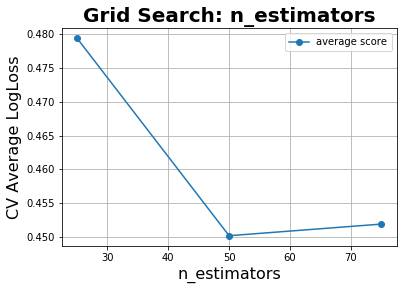

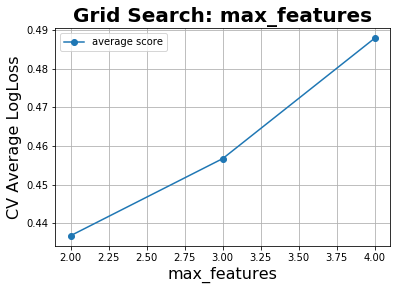

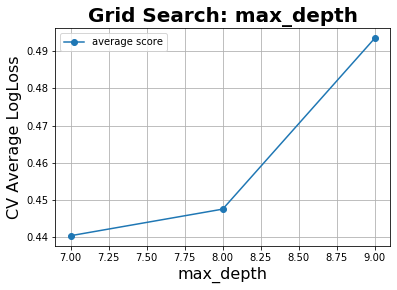

In [20]:
plot_rf_param_tuning_result(model_tuning, 'n_estimators')
plot_rf_param_tuning_result(model_tuning, 'max_features')
plot_rf_param_tuning_result(model_tuning, 'max_depth')

In [21]:
# ベストパラメタ
print('* Best Log Loss: {:.3f}'.format(-model_tuning.best_score_))
print('* Best parameter: {}'.format(model_tuning.best_params_))

* Best Log Loss: 0.429
* Best parameter: {'max_depth': 7, 'max_features': 2, 'n_estimators': 50}


## パラメタチューニング2回目: まとめ
* Best Log Loss: 0.429
  * 収束
* Best parameter: {'max_depth': 7, 'max_features': 2, 'n_estimators': 50}

Text(0.5, 1.0, 'Feature Importance')

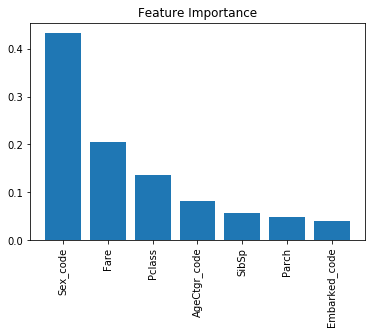

In [22]:
# Feature importance
model = model_tuning.best_estimator_

plot_df = pd.DataFrame([X_train.columns, model.feature_importances_]).T
plot_df.columns = ['Feature', 'Importance']
plot_df = plot_df.sort_values('Importance', ascending=False)

plt.bar(x=range(plot_df.shape[0]), height=plot_df['Importance'], tick_label=plot_df['Feature'])
plt.xticks(rotation=90)
plt.title('Feature Importance')

In [23]:
# Validation時の推定値を求める
y_pred_prob = np.repeat(-1.0, len(y_train))
y_pred_flg = np.repeat(-1.0, len(y_train))

for train_index, valid_index in skf.split(X_train, y_train):
    X_cv_train, y_cv_train = X_train.iloc[train_index], y_train[train_index]
    X_cv_valid = X_train.iloc[valid_index]
    
    cv_model = RandomForestClassifier(random_state=0, 
                                      n_estimators=model_tuning.best_params_['n_estimators'], 
                                      max_features=model_tuning.best_params_['max_features'], 
                                      max_depth=model_tuning.best_params_['max_depth'])
    cv_model.fit(X_cv_train, y_cv_train)
    
    y_pred_prob[valid_index] = [p[1] for p in cv_model.predict_proba(X_cv_valid)]
    y_pred_flg[valid_index] = cv_model.predict(X_cv_valid)

In [24]:
# Validation時の精度(accuracy)
accuracy = accuracy_score(y_pred=y_pred_flg, y_true=y_train)
print('Accuracy: {:.3f}'.format(accuracy))

Accuracy: 0.806


In [25]:
# Validation時のLog Loss
print('Log Loss: {:.3f}'.format(log_loss(y_pred=y_pred_prob, y_true=y_train)))

Log Loss: 0.429


           Survived  count
PredProb                  
00_0.0-0.1    10.9%    129
01_0.1-0.2    10.1%    278
02_0.2-0.3    27.9%     68
03_0.3-0.4    35.7%     70
04_0.4-0.5    47.9%     71
05_0.5-0.6    44.4%     36
06_0.6-0.7    54.3%     35
07_0.7-0.8    87.3%     55
08_0.8-0.9    88.9%     54
09_0.9-1.0    95.8%     95


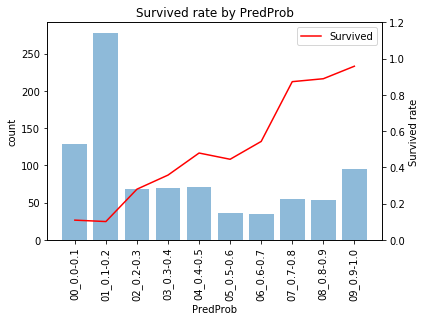

In [26]:
# Validationの推定値と生存割合の関係
plot_df = pd.DataFrame(
    {'PredProb': y_pred_prob, 
     'Type': np.repeat('train', len(y_pred_prob)), 
     'Survived': y_train})

plot_survival_rate('PredProb', plot_df, bins=np.linspace(0, 1, 11), label_format='{:02}_{:.1f}-{:.1f}')

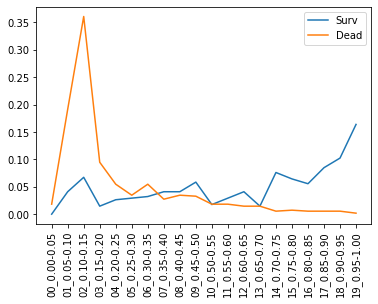

In [27]:
# 生存者／死亡者ごとに推定値でのヒストグラムをplot
survived_flg = (y_train == 1)

survived_prob = y_pred_prob[survived_flg]
binned_prob = get_binned_data(survived_prob, bins=np.linspace(0, 1, 21), label_format='{:02}_{:.2f}-{:.2f}')

survived_count = binned_prob.value_counts().sort_index()
survived_rate = survived_count / sum(survived_count)

dead_prob = y_pred_prob[~survived_flg]
binned_prob = get_binned_data(dead_prob, bins=np.linspace(0, 1, 21), label_format='{:02}_{:.2f}-{:.2f}')

dead_count = binned_prob.value_counts().sort_index()
dead_rate = dead_count / sum(dead_count)

for key in survived_rate.index:
    if key not in dead_rate.index:
        dead_rate = dead_rate.append(pd.Series({key: 0.0})).sort_index()
    
for key in dead_rate.index:
    if key not in survived_rate.index:
        survived_rate = survived_rate.append(pd.Series({key: 0.0})).sort_index()
    
plt.xticks(rotation=90)
plt.plot(survived_rate)
plt.plot(dead_rate)
plt.legend(['Surv','Dead'])

In [28]:
# 予測結果を出力する
model = model_tuning.best_estimator_

y_pred = model.predict(X_test)
y_pred = pd.DataFrame({'PassengerId': titanic_test['PassengerId'], 'Survived': y_pred})
y_pred.to_csv('./result/14_random_forest.csv', index=False)

In [29]:
# 平均生存率
surv_rate = np.mean(y_pred['Survived'])
print('Mean Survival Rate: {:.3f}'.format(surv_rate))

Mean Survival Rate: 0.335


In [30]:
# まとめ
print('* Best Log Loss: {:.3f}'.format(-model_tuning.best_score_))
print('* Best parameter: {}'.format(model_tuning.best_params_))
print('* Accuracy(valid): {:.3f}'.format(accuracy))
print('* Accuracy(test): 0.775')

* Best Log Loss: 0.429
* Best parameter: {'max_depth': 7, 'max_features': 2, 'n_estimators': 50}
* Accuracy(valid): 0.806
* Accuracy(test): 0.775


# まとめ
* Best Log Loss: 0.429
* Best parameter: {'max_depth': 7, 'max_features': 2, 'min_samples_split': 2, 'n_estimators': 50}
* Accuracy(valid): 0.806
* Accuracy(test): 0.775